# Face Detection Using Viola-Jones (Test)

In [29]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")
# print(face_cascade.empty())
img = cv2.imread('yalefaces2/subject01.gif.jpg')
# print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade.empty()

False

In [30]:

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[111  66 153 153]]


# Rename Images from GIF to JPG

In [ ]:
import os 
  
for count, filename in enumerate(os.listdir("yalefaces/")): 
    dst = "yalefaces/" + filename + ".jpg"
    src = "yalefaces/" + filename 
#     dst = 'xyz'+ dst  
    os.rename(src, dst)
#     print(dst, src)
#     break
# os.listdir('yalefaces/')

# Converting GIF to JPG

In [24]:
from PIL import Image
import os 
for count, filename in enumerate(os.listdir("yalefaces/")):
    if ".info" in filename or ".csv" in filename or filename == "Dockerfile":
        continue
    else:
        im1 = Image.open("yalefaces/"+filename)
        im1.save("yalefaces2/"+filename)

# Training our own HaarCascade Classifier (Test)

In [18]:
import pandas as pd
import numpy as np

In [19]:
df_faces = pd.read_csv("yalefaces/yalefaces.csv", names = ["Label","x","y","w","h","Path","W","H"])
df_faces["No. of Faces"] = [1]*df_faces.shape[0]
hc_df = df_faces[["Path","No. of Faces","x","y","w","h"]]
hc_df

,Path,No. of Faces,x,y,w,h
0,subject01.gif.jpg,1,105,38,160,198
1,subject01.glasses.gif.jpg,1,107,47,149,188
2,subject01.glasses.jpg,1,107,41,149,195
3,subject01.happy.jpg,1,106,47,151,190
4,subject01.leftlight.jpg,1,104,51,162,181
...,...,...,...,...,...,...
161,subject15.rightlight.jpg,1,94,78,161,164
162,subject15.sad.jpg,1,89,67,167,167
163,subject15.sleepy.jpg,1,83,57,167,174
164,subject15.surprised.jpg,1,69,54,180,189


In [45]:
np.savetxt("yalefaces/yalefaces.info", hc_df.values, fmt='%s %d %d %d %d %d')

In [55]:
cv2.__version__

'4.4.0'

Matplotlib is building the font cache; this may take a moment.


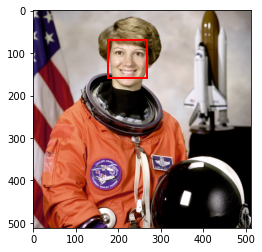

In [2]:
from skimage import data
from skimage.feature import Cascade

import matplotlib.pyplot as plt
from matplotlib import patches

# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade.
detector = Cascade(trained_file)

img = data.astronaut()

detected = detector.detect_multi_scale(img=img,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(60, 60),
                                       max_size=(123, 123))

plt.imshow(img)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

In [4]:
import cv2
help(cv2.HOGDescriptor().detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.HOGDescriptor instance
    detectMultiScale(img[, hitThreshold[, winStride[, padding[, scale[, finalThreshold[, useMeanshiftGrouping]]]]]]) -> foundLocations, foundWeights
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .       of rectangles.
    .       @param img Matrix of the type CV_8U or CV_8UC3 containing an image where objects are detected.
    .       @param foundLocations Vector of rectangles where each rectangle contains the detected object.
    .       @param foundWeights Vector that will contain confidence values for each detected object.
    .       @param hitThreshold Threshold for the distance between features and SVM classifying plane.
    .       Usually it is 0 and should be specified in the detector coefficients (as the last free coefficient).
    .       But if the free coefficient is omitted (which is allowed), you c

In [6]:
import cv2

In [11]:
image = cv2.imread("yalefaces2/subject01.gif.jpg")
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
image = cv2.rectangle(image, (0,0), (8,8),(0,255,0),3)
image = cv2.rectangle(image, (188,36), (40,80),(0,255,0),3)

In [14]:
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Viola Jones + Eigen Faces (PCA) (OpenCV)

## Detecting Face Using Viola Jones

In [98]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")
# print(face_cascade.empty())
img = cv2.imread('yalefaces2/subject05.sad.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# face_cascade.empty()

In [99]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[101  50 165 165]]


## Algorithm training using EigenFaces

##### Reference --> https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/

In [47]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")

images = []
ndim = (40,40)
df_faces = pd.read_csv("yalefaces/yalefaces.csv", names = ["Label","x","y","w","h","Path","W","H"])
images_paths = df_faces["Path"].values
Labels = df_faces['Label'].values
for count , image_path in enumerate(images_paths):
    img = cv2.imread("yalefaces2/" + image_path, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    if faces != () :
        x,y,w,h = faces[0][0], faces[0][1], faces[0][2], faces[0][3]
        img = img[y:y+h, x:x+w]
#         img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        img = cv2.resize(img, ndim)
        images.append(img.flatten())
    else:
        img = cv2.resize(img, ndim)
        images.append(img.flatten())
#     cv2.imshow("image",img)
#     cv2.waitKey()
#     cv2.destroyAllWindows()

In [48]:
images = np.array(images).T # Shape of image vector = (40*40) x 166 [N^2 X M]

# Show First image

temp_image = images[:,0]
# print(temp_image.shape)
temp_image = np.reshape(temp_image, ndim)
cv2.imshow("image", temp_image)
cv2.waitKey()
cv2.destroyAllWindows()
# print(temp_image.shape)

In [57]:
X, Y = images, Labels
X.shape,Y.shape

((1600, 166), (166,))